From this [blog](https://guilles.website/2018/06/12/tutorial-exploring-raster-and-vector-geographic-data-with-rasterio-and-geopandas/)

In [1]:
%matplotlib inline
import geopandas
import rasterio
import os
import numpy as np
import rasterio.features
from rasterio.plot import reshape_as_image
from shapely.geometry import Polygon
import matplotlib.pyplot as plt

In [6]:
# File to convert
hyp3_name = 'S1BB_20171224T070624_20180105T070624_VVP012_INT40_G_ueF_0A8B'
example = os.path.join('..','hyp3_downloads','p81f1048_10x2_2',hyp3_name,f'{hyp3_name}_dem_clip.tif')
to_convert = os.path.join('mapped_landslides','large_landslidesV2.shp')
to_save = f'{to_convert.split(".")[0]}.tif'

# Read in files
print('reading...')
gdf = geopandas.read_file(to_convert)
raster_r = rasterio.open(example)
raster = raster_r.read()

reading...


In [7]:
# Reproject
if str(gdf.crs).upper() != str(raster_r.crs):
    print('reprojecting...')
    gdf = gdf.to_crs(str(raster_r.crs))

# Clip
print('clipping...')
r_bounds = raster_r.bounds
bounding_box = Polygon([(r_bounds.left, r_bounds.top), (r_bounds.right, r_bounds.top), (r_bounds.right, r_bounds.bottom),
                        (r_bounds.left, r_bounds.bottom), (r_bounds.left, r_bounds.top)])

if not all(gdf.within(bounding_box)):
    gdf = geopandas.clip(gdf, bounding_box)

# Rasterize
print('rasterizing...')
landslides = rasterio.features.rasterize(
    [(x.geometry, 1) for i, x in gdf.iterrows()],
    out_shape=raster_r.shape,
    transform=raster_r.transform,
    fill=0,
    dtype=rasterio.uint8)

# Write to file
print('writing...')
profile = raster_r.profile
profile.update(dtype=rasterio.uint8, count=1, compress='lzw', nodata=0)
landslides[landslides < 1] = 0
with rasterio.open(to_save, 'w', **profile) as out:
    out.write_band(1, landslides)

print('done!')

reprojecting...
clipping...
rasterizing...
writing...
done!


In [11]:
pad = 25
p_bounds = gdf.bounds
left, bottom, right, top = list(gdf.total_bounds)
landslide_box = Polygon([(left, top), (right, top), (right, bottom),(left, bottom), (left, top)])

print('rasterizing...')
rasterized = rasterio.features.rasterize(
    [(landslide_box, 1)],
    out_shape=raster_r.shape,
    transform=raster_r.transform,
    fill=0,
    dtype=rasterio.uint8)

(bottom, top), (left, right) = [(x.min(),x.max()) for x in np.where(rasterized == 1)]

# Print in MintPy format (S:N,W:E)
print(f'{bottom-pad}:{top+pad},{left-pad}:{right+pad}')

rasterizing...
4232:6352,884:5214


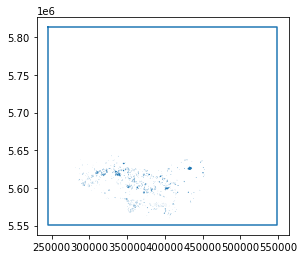

In [9]:
gdf.plot()
plt.plot(*bounding_box.exterior.xy)
plt.show()